In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import cifar10
from sklearn.manifold import Isomap
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix, homogeneity_score, completeness_score, classification_report
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestCentroid

In [2]:
PROJECT_PARAMS = {
    'sample_size': 20000,
    'target_dim': 2,
    'n_clusters': 10,
    'random_seed': 42,


    'isomap_neighbors': 30,


    'spec_neighbors': 10,

    'class_names': [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"
    ]
}

In [3]:
def load_and_prep_cifar10(params):

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()


    x_train_flat = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
    y_train_flat = y_train.flatten()


    np.random.seed(params['random_seed'])
    indices = np.random.choice(len(x_train_flat), params['sample_size'], replace=False)

    X_sub = x_train_flat[indices]
    y_sub = y_train_flat[indices]

    print(f"Μορφή Δεδομένων: {X_sub.shape}")
    return X_sub, y_sub


X, y_true = load_and_prep_cifar10(PROJECT_PARAMS)

Μορφή Δεδομένων: (20000, 3072)


In [4]:
def evaluate_clustering(y_true, labels_pred, dataset_name="Data"):

    ari = adjusted_rand_score(y_true, labels_pred)
    homo = homogeneity_score(y_true, labels_pred)
    comp = completeness_score(y_true, labels_pred)


    print(f" ARI (Adjusted Rand Index):  {ari:.3f}")
    print(f" Homogeneity :  {homo:.3f}")
    print(f" Completeness :   {comp:.3f}")


In [5]:
def run_dimensionality_reduction_isomap(X, params):
    start = time.time()


    embedding = Isomap(n_components=params['target_dim'],
                       n_neighbors=params['isomap_neighbors'],
                       n_jobs=-1)


    X_2d = embedding.fit_transform(X)

    elapsed = time.time() - start
    print(f" Χρόνος εκτέλεσης {elapsed:.2f} seconds.")


    return X_2d, embedding


X_2d, iso_model = run_dimensionality_reduction_isomap(X, PROJECT_PARAMS)

 Χρόνος εκτέλεσης 415.95 seconds.


In [6]:
def run_clustering_and_matching(X_reduced, y_true, params):

    start = time.time()


    spec_cl = SpectralClustering(
        n_clusters=params['n_clusters'],
        affinity='nearest_neighbors',
        n_neighbors=params['spec_neighbors'],
        assign_labels='kmeans',
        random_state=params['random_seed'],
        n_jobs=-1
    )
    labels_raw = spec_cl.fit_predict(X_reduced)

    elapsed = time.time() - start
    print(f" Χρόνος εκτέλεσης clustering {elapsed:.2f} seconds.")


    cm = confusion_matrix(y_true, labels_raw)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    mapping = {c: r for r, c in zip(rows, cols)}
    labels_mapped = np.array([mapping[l] for l in labels_raw])

    return labels_raw, labels_mapped


labels_raw, labels_mapped = run_clustering_and_matching(X_2d, y_true, PROJECT_PARAMS)

evaluate_clustering(y_true, labels_mapped, dataset_name="CIFAR-10 (Isomap 2D)")

acc = accuracy_score(y_true, labels_mapped)
print(f" Accuracy : {acc:.3f}")

 Χρόνος εκτέλεσης clustering 25.93 seconds.
 ARI (Adjusted Rand Index):  0.035
 Homogeneity :  0.070
 Completeness :   0.071
 Accuracy : 0.198


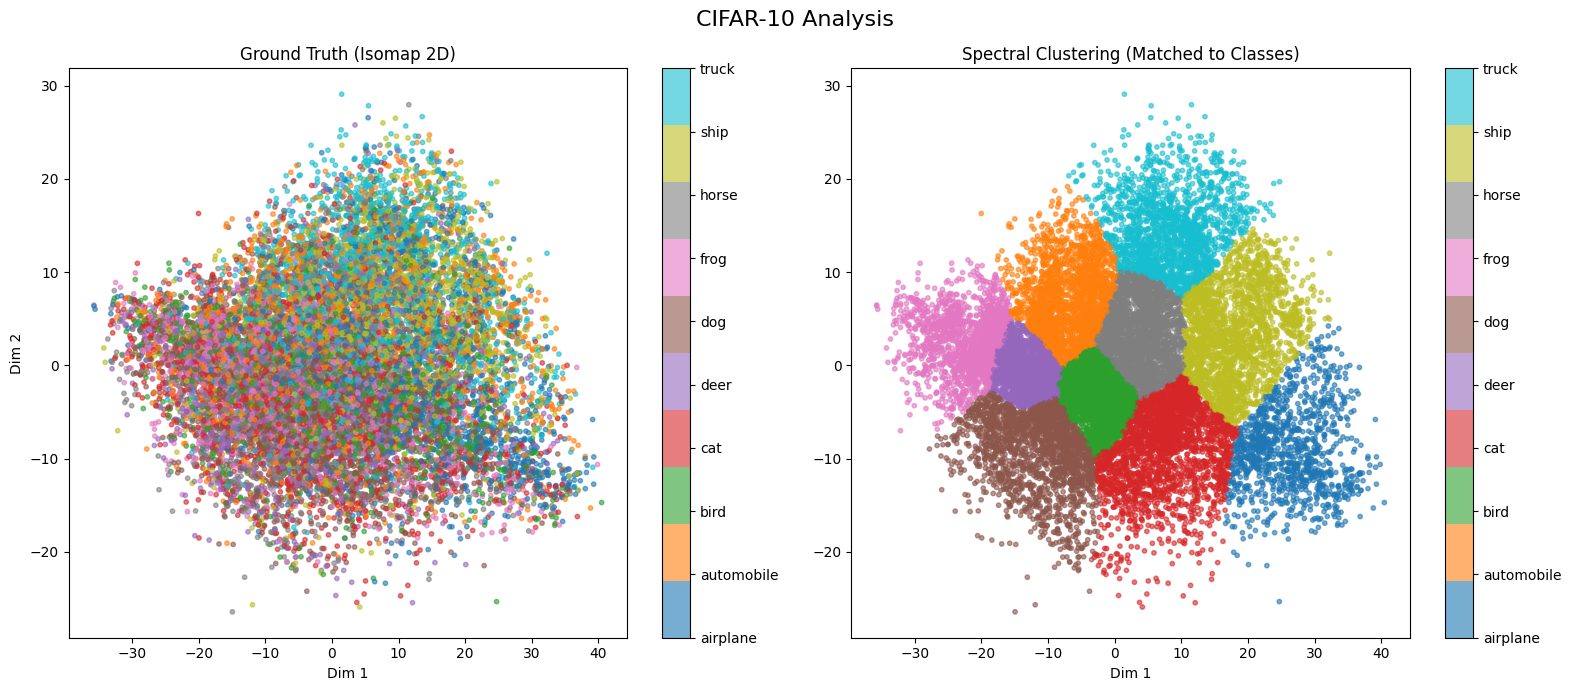

In [7]:
def visualize_results_matched(X_2d, y_true, labels_mapped, config):
    plt.figure(figsize=(16, 7))


    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='tab10', s=10, alpha=0.6)
    cbar1 = plt.colorbar(scatter1, ticks=range(10))
    cbar1.ax.set_yticklabels(config['class_names'])
    plt.title("Ground Truth (Isomap 2D)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")


    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_mapped, cmap='tab10', s=10, alpha=0.6)
    cbar2 = plt.colorbar(scatter2, ticks=range(10))
    cbar2.ax.set_yticklabels(config['class_names'])
    plt.title("Spectral Clustering (Matched to Classes)")
    plt.xlabel("Dim 1")

    plt.suptitle("CIFAR-10 Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_results_matched(X_2d, y_true, labels_mapped, PROJECT_PARAMS)

In [8]:
def analyze_k_behavior(X_2d, y_true):
    k_values = [2, 5, 10, 15, 20]



    print(f"{'Clusters':<10} | {'ARI':<6} | {'Homogenenity':<11} | {'Completeness':<12}")


    for k in k_values:

        model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                   random_state=42, n_neighbors=10, n_jobs=-1)
        labels = model.fit_predict(X_2d)


        ari = adjusted_rand_score(y_true, labels)
        homo = homogeneity_score(y_true, labels)
        comp = completeness_score(y_true, labels)

        print(f" {k:<9} | {ari:.3f}  | {homo:.3f}       | {comp:.3f}")


analyze_k_behavior(X_2d, y_true)

Clusters   | ARI    | Homogenenity | Completeness
 2         | 0.023  | 0.027       | 0.088
 5         | 0.038  | 0.054       | 0.078
 10        | 0.035  | 0.070       | 0.071
 15        | 0.030  | 0.076       | 0.065
 20        | 0.025  | 0.078       | 0.060


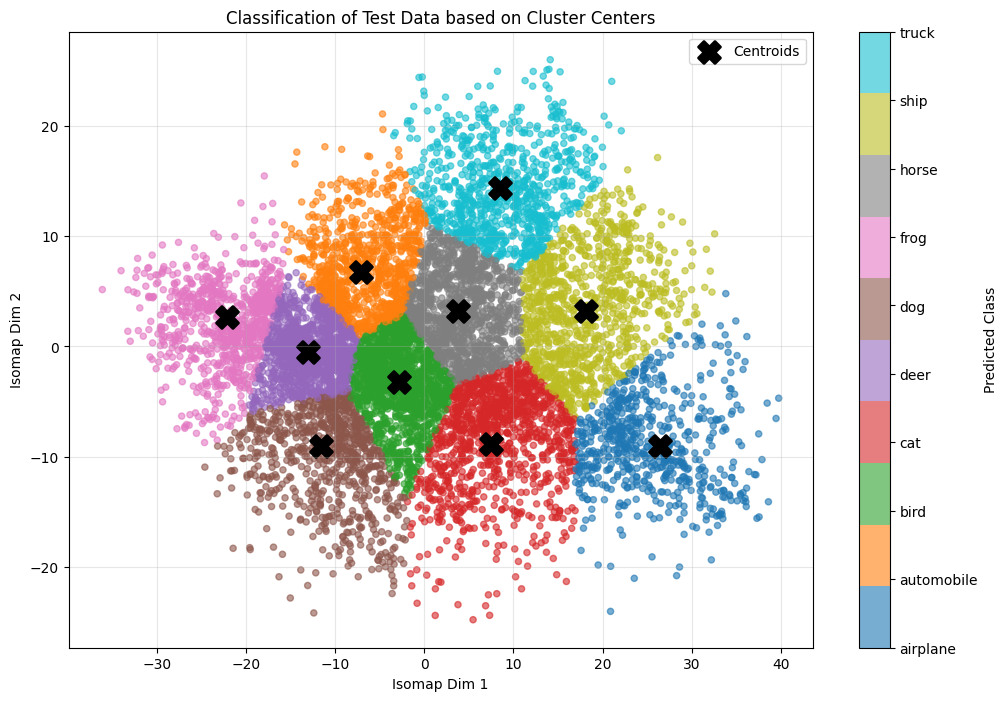


 Τελικό Accuracy στο Test Set: 0.197

              precision    recall  f1-score   support

    airplane       0.33      0.21      0.26      1000
  automobile       0.19      0.17      0.18      1000
        bird       0.15      0.21      0.17      1000
         cat       0.13      0.15      0.14      1000
        deer       0.16      0.20      0.17      1000
         dog       0.21      0.16      0.19      1000
        frog       0.21      0.18      0.19      1000
       horse       0.13      0.15      0.14      1000
        ship       0.25      0.25      0.25      1000
       truck       0.33      0.28      0.31      1000

    accuracy                           0.20     10000
   macro avg       0.21      0.20      0.20     10000
weighted avg       0.21      0.20      0.20     10000



In [14]:
def classify_test_data_centers(iso_model, X_train_2d, labels_mapped_train, params):



    (_, _), (x_test_full, y_test_full) = cifar10.load_data()

    np.random.seed(params['random_seed'])
    idx = np.random.choice(len(y_test_full), 10000, replace=False)
    X_test_flat = x_test_full[idx].reshape(10000, -1).astype('float32') / 255.0
    y_test_sub = y_test_full[idx].flatten()



    X_test_2d = iso_model.transform(X_test_flat)


    clf = NearestCentroid()
    clf.fit(X_train_2d, labels_mapped_train)


    test_preds = clf.predict(X_test_2d)
    centers = clf.centroids_


    plt.figure(figsize=(12, 8))


    scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=test_preds, cmap='tab10', s=20, alpha=0.6)


    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=250, label='Centroids', linewidth=2)


    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(params['class_names'])
    cbar.set_label('Predicted Class')

    plt.title("Classification of Test Data based on Cluster Centers")
    plt.legend()
    plt.xlabel("Isomap Dim 1")
    plt.ylabel("Isomap Dim 2")
    plt.grid(True, alpha=0.3)
    plt.show()

    return test_preds, y_test_sub

test_preds, y_test_sub = classify_test_data_centers(iso_model, X_2d, labels_mapped, PROJECT_PARAMS)
test_acc = accuracy_score(y_test_sub, test_preds)
print(f"\n Τελικό Accuracy στο Test Set: {test_acc:.3f}\n")
print(classification_report(y_test_sub, test_preds, target_names=PROJECT_PARAMS['class_names']))

 Χρόνος εκτέλεσης 543.77 seconds.
 ARI (Adjusted Rand Index):  0.028
 Homogeneity :  0.072
 Completeness :   0.088
 Accuracy: 0.200


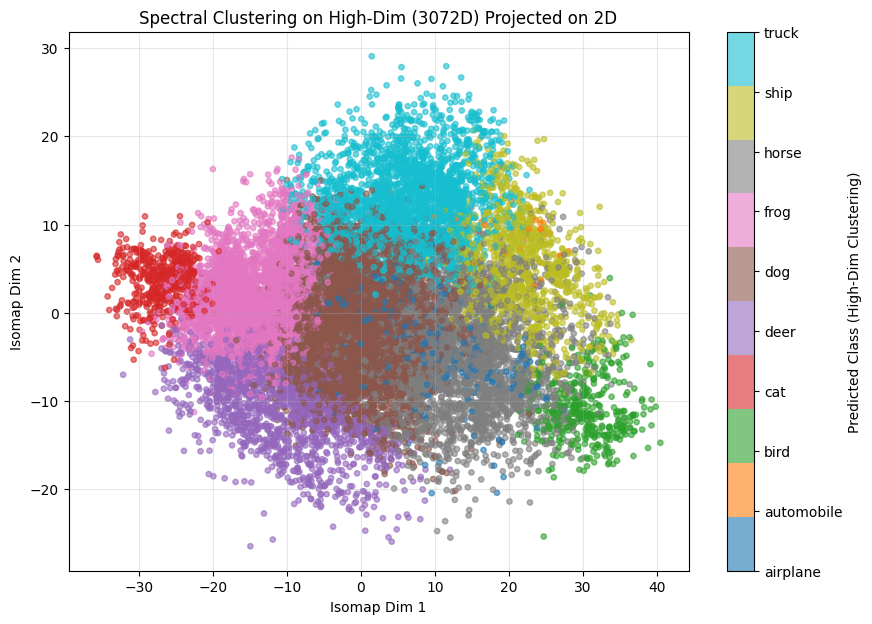

              precision    recall  f1-score   support

    airplane       0.33      0.21      0.26      1000
  automobile       0.19      0.17      0.18      1000
        bird       0.15      0.21      0.17      1000
         cat       0.13      0.15      0.14      1000
        deer       0.16      0.20      0.17      1000
         dog       0.21      0.16      0.19      1000
        frog       0.21      0.18      0.19      1000
       horse       0.13      0.15      0.14      1000
        ship       0.25      0.25      0.25      1000
       truck       0.33      0.28      0.31      1000

    accuracy                           0.20     10000
   macro avg       0.21      0.20      0.20     10000
weighted avg       0.21      0.20      0.20     10000



In [16]:
def run_spectral_on_raw_data(X_high_dim, X_2d_for_plot, y_true, params):

    start = time.time()

    spec_cl = SpectralClustering(
        n_clusters=params['n_clusters'],
        affinity='nearest_neighbors',
        n_neighbors=15,               # Αυξάνουμε λίγο τους γείτονες λόγω αραιότητας χώρου
        assign_labels='kmeans',
        random_state=params['random_seed'],
        n_jobs=-1
    )


    labels_pred_raw = spec_cl.fit_predict(X_high_dim)

    elapsed = time.time() - start
    print(f" Χρόνος εκτέλεσης {elapsed:.2f} seconds.")


    evaluate_clustering(y_true, labels_pred_raw, dataset_name="3072D Raw Data")


    cm = confusion_matrix(y_true, labels_pred_raw)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    mapping = {c: r for r, c in zip(rows, cols)}
    labels_mapped = np.array([mapping[l] for l in labels_pred_raw])

    # Metrics Calculation
    acc = accuracy_score(y_true, labels_mapped)
    print(f" Accuracy: {acc:.3f}")

    # Plotting
    plt.figure(figsize=(10, 7))

    scatter = plt.scatter(X_2d_for_plot[:, 0], X_2d_for_plot[:, 1], c=labels_mapped, cmap='tab10', s=15, alpha=0.6)
    cbar = plt.colorbar(scatter, ticks=range(10))


    names = params['class_names']


    cbar.ax.set_yticklabels(names)
    cbar.set_label('Predicted Class (High-Dim Clustering)')

    plt.title(f"Spectral Clustering on High-Dim (3072D) Projected on 2D")
    plt.xlabel("Isomap Dim 1")
    plt.ylabel("Isomap Dim 2")
    plt.grid(True, alpha=0.3)
    plt.show()


run_spectral_on_raw_data(X, X_2d, y_true, PROJECT_PARAMS)
print(classification_report(y_test_sub, test_preds, target_names=PROJECT_PARAMS['class_names']))